In [1]:
# Base packages
import dill
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from wordcloud import WordCloud
import os,re, nltk, spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Path
folders = './final/'
file_url = folders + 'lematize_corpus_vec.csv'

model_folders = './models/'
dest_model_file_a = model_folders + 'lda_tfidf_tri_a.pkl'
dest_model_file_b = model_folders + 'lda_tfidf_tri_b.jlb'
dest_model_file_c = model_folders + 'lda_tfidf_tri_c_dill.pkl'

gs_model_bk = './gs_models/tfidf_tri.model'

# Init
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
GRAMMAGE = (1, 3)
%matplotlib inline

# Custom
%run -i ./python-code/helper.py
%run -i ./python-code/config.py
%run -i ./python-code/nlp_scripts.py

C:\Users\Shaynie\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [3]:
frame = pd.read_csv(file_url, sep='|', encoding="utf-8")
frame.head()

,text,list_text,lemma_text
0,People with an irregular heart beat condition...,"['people', 'with', 'an', 'irregular', 'heart',...",peopl irregular heart beat condit should be cl...
1,Politicians in the Catholic Republic of Irelan...,"['politicians', 'in', 'the', 'catholic', 'repu...",politician cathol republ ireland have overwhel...
2,In the winter months temperatures and humidity...,"['in', 'the', 'winter', 'months', 'temperature...",winter month temperatur humid level plummet as...
3,A system of special measures designed to impro...,"['system', 'of', 'special', 'measures', 'desig...",system special measur design improv fail hospi...
4,A can be hard enough to get on your own Add in...,"['can', 'be', 'hard', 'enough', 'to', 'get', '...",can be hard enough get own add challeng sleep ...


In [4]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25737 entries, 0 to 25736
Data columns (total 3 columns):
text          25737 non-null object
list_text     25737 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 603.3+ KB


In [5]:
frame = frame[pd.notnull(frame['lemma_text'])]
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25729 entries, 0 to 25736
Data columns (total 3 columns):
text          25729 non-null object
list_text     25729 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 804.0+ KB


In [6]:
corpus = frame['lemma_text'].values

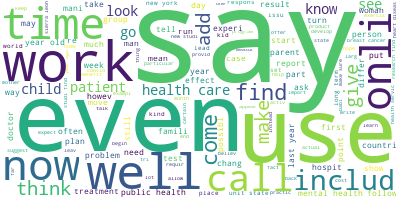

In [7]:
# Join the different processed title together.
long_string = ','.join(corpus)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [8]:
# Split corpus into TRAIN, TEST, HOLDON
data_train = corpus[:TRAIN_SIZE]
TRAIN_SIZE = TRAIN_SIZE +1
TEST_SIZE = TEST_SIZE + TRAIN_SIZE
data_test = corpus[TRAIN_SIZE:TEST_SIZE]
TEST_SIZE = TEST_SIZE + 1
data_holdon = corpus[TEST_SIZE:]

In [7]:
# Create the Document-Word matrix
vectorizer = TfidfVectorizer(ngram_range = GRAMMAGE,
                             analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=M_STOP_WORDS,   # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(corpus)

In [8]:
# 8. Check the Sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.16637774938826771 %


In [9]:
# Build LDA Model
lda_model = LDA(n_topics=E_TOPICS,       # Number of topics
              max_iter=10,               # Max learning iterations
              learning_method='online',   
              random_state=100,          # Random state
              batch_size=128,            # n docs in each learning iter
              evaluate_every = -1,       # compute perplexity every n iters, default: Don't
              n_jobs = -1,               # Use all available CPUs
             )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=6, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [10]:
# 10
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -3772179.1047349484
Perplexity:  105288.34364639182
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 6,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [11]:
## GridSearchCV
# Define Search Param
search_params = {'n_components': N_COMPONENTS, 'learning_decay': LEARNING_DECAY}

# Init the Model
lda = LDA()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params,n_jobs=-1)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_components': [6, 10, 15, 20, 25, 30, 50], 'learning_decay': ['.3', '.5', '.7', '.9']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': '.9', 'n_components': 6}
Best Log Likelihood Score:  -1364541.2295296246
Model Perplexity:  107167.1809242478


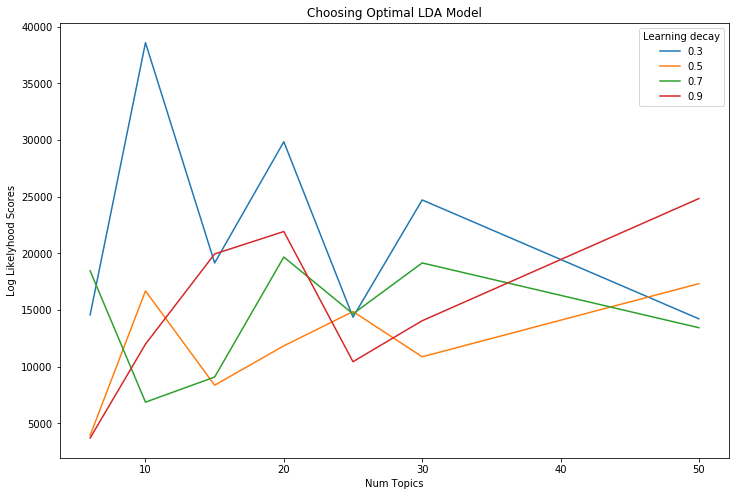

In [13]:
# Get Log Likelyhoods from Grid Search Output
n_topics = search_params['n_components']
learning_decay = LEARNING_DECAY
one_third = len(n_topics)
two_third = one_third*2
three_fourth = one_third*3

gscore = dict(model.cv_results_)
log_likelyhoods_3 = gscore['std_train_score'][0:one_third]
log_likelyhoods_5 = gscore['std_train_score'][one_third:two_third]
log_likelyhoods_7 = gscore['std_train_score'][two_third:three_fourth]
log_likelyhoods_9 = gscore['std_train_score'][three_fourth:]


# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_3, label='0.3')
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


### 1. Saving Models 

In [14]:
# Have: best_lda_model


## ----------------------------------------------------------
## ----------------------------------------------------------
## Pickle
## ----------------------------------------------------------
pickle.dump(best_lda_model,open(dest_model_file_a,'wb'))

## Joblib
## ----------------------------------------------------------
joblib.dump(best_lda_model, dest_model_file_b)

## Dill
## ----------------------------------------------------------
dill.dump(best_lda_model, open(dest_model_file_c,'wb'))



## ----------------------------------------------------------
## ----------------------------------------------------------
## Backup GridSearchCV models
## ----------------------------------------------------------
dill.dump(model, open(gs_model_bk,'wb'))

## Best topic
## ----------------------------------------------------------
BEST_TOPICS = model.best_params_['n_components']

In [ ]:
# best_lda_model = dill.load(open(dest_model_file_c,'rb'))

In [15]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(model.best_params_['n_components'])]

# index names
docnames = ["Doc" + str(i) for i in range(len(corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.01,0.94,0.01,0.01,0.01,0.01,1
Doc1,0.03,0.87,0.03,0.03,0.03,0.03,1
Doc2,0.01,0.94,0.01,0.01,0.01,0.01,1
Doc3,0.01,0.94,0.01,0.01,0.01,0.01,1
Doc4,0.01,0.96,0.01,0.01,0.01,0.01,1
Doc5,0.01,0.94,0.01,0.01,0.02,0.01,1
Doc6,0.01,0.63,0.01,0.01,0.34,0.01,1
Doc7,0.02,0.9,0.02,0.02,0.02,0.02,1
Doc8,0.02,0.92,0.02,0.02,0.02,0.02,1
Doc9,0.01,0.94,0.01,0.01,0.01,0.01,1


In [16]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,23776
1,5,752
2,4,396
3,0,320
4,2,244
5,3,241


In [17]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\Shaynie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      -83.917595   32.366501       1        1  82.187943
5      -52.201405  -96.792755       2        1   4.593879
4       80.437584 -106.541351       3        1   4.257366
0      130.696259   16.593578       4        1   3.108357
2       20.827021  -10.386171       5        1   2.988450
3       29.119106  102.443451       6        1   2.864006, topic_info=       Category        Freq                 Term       Total  loglift  logprob
term                                                                          
53790   Default  120.000000                  fat  120.000000  30.0000  30.0000
100690  Default  162.000000                  nhs  162.000000  29.0000  29.0000
121218  Default   64.000000              protein   64.000000  28.0000  28.0000
16241   Default   84.000000               breast   84.000000  27.0000  27.0000
17875   Default  124.000000               calori  124.000000  26.0000  26.0000
104146  Default   42.000000                  oil   42.000000  25.0000  25.0000
66476   Default  121.000000              healthi  121.000000  24.0000  24.0000
16242   Default   44.000000        breast cancer   44.000000  23.0000  23.0000
163726  Default   60.000000              vitamin   60.000000  22.0000  22.0000
4849    Default   91.000000              alcohol   91.000000  21.0000  21.0000
134268  Default   37.000000                 salt   37.000000  20.0000  20.0000
136934  Default   59.000000                 serv   59.000000  19.0000  19.0000
58471   Default   36.000000                fresh   36.000000  18.0000  18.0000
125795  Default   27.000000                recip   27.000000  17.0000  17.0000
31675   Default   38.000000                 cook   38.000000  16.0000  16.0000
162280  Default   50.000000                veget   50.000000  15.0000  15.0000
55897   Default   39.000000                 fish   39.000000  14.0000  14.0000
126405  Default   49.000000                  red   49.000000  13.0000  13.0000
62484   Default   43.000000                green   43.000000  12.0000  12.0000
150593  Default   31.000000                sweet   31.000000  11.0000  11.0000
92332   Default   53.000000                 meal   53.000000  10.0000  10.0000
23496   Default   26.000000                chees   26.000000   9.0000   9.0000
62023   Default   30.000000                 gram   30.000000   8.0000   8.0000
55165   Default   29.000000                fiber   29.000000   7.0000   7.0000
56138   Default   25.000000               flavor   25.000000   6.0000   6.0000
46952   Default   44.000000                  egg   44.000000   5.0000   5.0000
42000   Default   24.000000                 dish   24.000000   4.0000   4.0000
23698   Default   31.000000              chicken   31.000000   3.0000   3.0000
148703  Default  101.000000                sugar  101.000000   2.0000   2.0000
151541  Default   31.000000                 tast   31.000000   1.0000   1.0000
...         ...         ...                  ...         ...      ...      ...
71153    Topic6    5.514866                  hpv    8.954125   3.0683  -7.4348
131816   Topic6    0.571216             ride toy    0.929984   3.0655  -9.7023
168065   Topic6    0.600991           woman dens    0.994157   3.0496  -9.6515
143977   Topic6    1.017751               squibb    1.692094   3.0446  -9.1247
97958    Topic6    1.017751          myer squibb    1.692094   3.0446  -9.1247
16646    Topic6    1.017751  bristol myer squibb    1.692094   3.0446  -9.1247
72577    Topic6    0.560937   immunotherapi drug    0.943003   3.0335  -9.7204
168066   Topic6    0.572233    woman dens breast    0.965941   3.0294  -9.7005
68690    Topic6    0.535395       hippocr health    0.906766   3.0261  -9.7670
90631    Topic6    0.765564      man testosteron    1.356397   2.9810  -9.4094
71172    Topic6    1.456073           hpv vaccin    3.068902   2.8074  -8.7665
71160    Topic6  

In [19]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords

,aaa,aafter,aall,aalmost,aan,aand,aani,aanyth,aap,aap committe,...,zucchini round,zucchini round zucchini,zucchini salt,zucchini salt ground,zucchini veggi,zucchini veggi tangi,zucker,zuckerman,zumba,zumba class
Topic0,0.166670,0.166669,0.166669,0.16667,0.166669,0.166669,0.166670,0.166670,0.166669,0.166672,...,0.208508,0.346289,0.169786,0.346289,0.346289,0.346289,0.166670,0.166669,0.166669,0.166669
Topic1,1.171571,1.114797,2.117774,0.65051,1.979894,4.000783,0.828026,0.619322,3.100953,0.619584,...,0.166790,0.166739,0.166697,0.166739,0.166739,0.166739,0.993345,1.677176,2.691069,1.335302
Topic2,0.166670,0.166669,0.166669,0.16667,0.166669,0.166669,0.166670,0.166671,0.166669,0.166672,...,0.166667,0.166667,0.166668,0.166667,0.166667,0.166667,0.166670,0.166798,0.166669,0.166669
Topic3,0.166670,0.166669,0.166669,0.16667,0.166669,0.166675,0.166670,0.166670,0.166705,0.166672,...,0.166667,0.166667,0.166668,0.166667,0.166667,0.166667,0.166670,0.166678,0.166669,0.166669
Topic4,0.166670,0.166669,0.166898,0.16667,0.166669,0.166727,0.166669,0.166670,0.166795,0.172436,...,0.166667,0.166667,0.166668,0.166667,0.166667,0.166667,0.166670,0.166669,0.167060,0.166669
Topic5,0.166670,0.166869,0.166669,0.16667,0.166669,0.166704,0.166669,0.168773,0.166669,0.166671,...,0.524040,0.170299,0.625654,0.170299,0.170299,0.170299,0.166670,0.166669,0.166671,0.166676


In [20]:
# Show top n keywords for each topic
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=18)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17
Topic 0,nhs,healthcar,menopaus,staff,solv,york time magazin,broadmoor,time magazin,innov,nurs,york time,new york time,copi book,resuscit,patient,introduct,reader,dnar
Topic 1,health,peopl,patient,studi,year,research,care,child,hospit,drug,cancer,make,woman,new,time,diseas,medic,doctor
Topic 2,mer,saudi,arabia,saudi arabia,coronavirus,camel,middl east,respiratori syndrom,hpv,east respiratori,middl east respiratori,east respiratori syndrom,mer virus,nhs,headle,host celest headle,guest host celest,celest headle
Topic 3,hpv,nhs,alcohol,testosteron,crisi,circumcis,hpv vaccin,cigarett,kerri,servic,bristol myer,julieanna,social care,jerki treat,makayla,squibb,myer squibb,bristol myer squibb
Topic 4,breast cancer,breast,mastectomi,nhs,prostat,mammographi,prostat cancer,brca,joli,cancer,patient,gilead,mammogram,ashya,proton,leg,nurs,need
Topic 5,oil,pepper,recip,dish,fat,chees,flavor,oliv,protein,salt,fiber,oliv oil,gluten,tomato,salad,gram,fresh,garlic


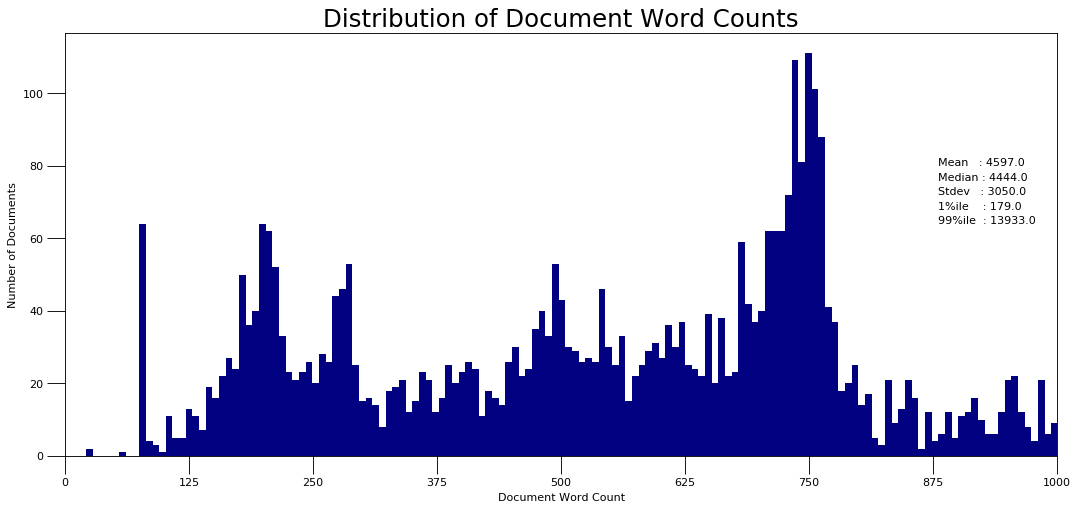

In [21]:
doc_lens = [len(d) for d in frame['list_text'].values]

# Plot
plt.figure(figsize=(16,7), dpi=80)
plt.hist(doc_lens, bins = 10000, color='navy')
plt.text(880, 80, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(880, 76, "Median : " + str(round(np.median(doc_lens))))
plt.text(880, 72, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(880, 68, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(880, 64, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [22]:
unseem_data = '''
Ultra-processed foods - such as chicken nuggets, ice cream and breakfast cereals - have been linked to early death and poor health, scientists say. 
Researchers in France and Spain say the amount of such food being eaten has soared.
Their studies are not definite proof of harm but do come hot on the heels of trials suggesting ultra-processed foods 
.
Experts expressed caution but called for further investigation. 
The term comes from a way of classifying food by how much industrial processing it has been through.
The lowest category is "unprocessed or minimally processed foods", which include: • fruit • vegetables • milk • meat • legumes such as lentils • seeds • grains such as rice • eggs
"Processed foods" have been altered to make them last longer or taste better - generally using salt, oil, sugar or fermentation.
This category includes: • cheese • bacon • home-made bread • tinned fruit and vegetables • smoked fish • beer
Then come "ultra-processed foods", which have been through more substantial industrial processing and often have long ingredient lists on the packet, including added preservatives, sweeteners or colour enhancers. 
If a product contains more than five ingredients, it is probably ultra-processed, says Prof Maira Bes-Rastrollo, of the University of Navarra, citing a maxim.
Examples include: • processed meat such as sausages and hamburgers • breakfast cereals or cereal bars • instant soups • sugary fizzy drinks • chicken nuggets • cake • chocolate • ice cream • mass-produced bread • many "ready to heat" meals such as pies and pizza | meal-replacement shakes 
, by the University of Navarra, in Spain, followed 19,899 people for a decade and assessed their diet every other year. There were 335 deaths during the study.
But for every 10 deaths among those eating the least ultra-processed food, there were 16 deaths among those eating the most (more than four portions a day).
, by the University of Paris, followed 105,159 people for five years and assessed their diet twice a year.
It showed those eating more ultra-processed food had worse heart health. 
Rates of cardiovascular disease were 277 per 100,000 people per year among those eating the most ultra-processed food, compared with 242 per 100,000 among those eating the least. 
The rapid increase of ultra-processed foods over less processed foods, "may drive a substantial burden of cardiovascular diseases in the next decades," said Dr Mathilde Touvier, of the University of Paris.
"[The] evidence is accumulating," said Dr Touvier, noting "increasing numbers of independent studies". Prof Bes-Rastrollo said she was "very certain" ultra-processed foods were bad for health.
Last year, a link was made with 
.
The challenge is being 100% sure. The studies have spotted a pattern between highly processed food and poor health but they cannot prove that one causes the other. 
Those who ate the most ultra-processed food were also more likely to have other unhealthy behaviours, such as smoking, which the researchers tried to account for. 
But there's no guarantee everything relevant was covered, says Kevin McConway, a professor of statistics at The Open University.
"These studies do increase my confidence that there's something real behind these associations - but I'm still far from sure."
The first trial of ultra-processed foods showed they led people to eat more and put on weight. 
Researchers at the US National Institutes of Health monitored every morsel of food that volunteers ate for a month.
And when given ultra-processed food, they ate 500 calories a day more than when they were given unprocessed meals.
Other suggestions include: 
These ideas still need researching.
While the term ultra-processed food may be new, the health advice will be very familiar: adopt a Mediterranean-style diet.
Such a diet includes plenty of minimally or unprocessed foods, such as fruit, vegetables, fish, nuts and seeds, beans, lentils and wholegrains, said Victoria Taylor, senior dietician at the British Heart Foundation.
"This, along with exercising regularly and not smoking, has been shown to be beneficial for lowering risk of heart and circulatory disease."
Measures such as taxation and marketing restrictions on ultra-processed foods, should be considered, said Prof Bes-Rastrollo, given the weight of evidence. 
There are certainly a lot of critics. 
The labelling of food as ultra-processed could be inconsistent, said Dr Gunter Kuhnle, an expert in nutrition and health at the University of Reading
"It is also not obvious why salami is considered to be ultra-processed, yet cheese, which often requires considerably more processing steps and additives, is not.  The classification combines a wide range of foods with very different potential impacts on health, which limits its usefulness as a basis for recommendations."
The studies were published in the British Medical Journal.
'''

In [23]:
# Define function to predict topic for a given text document.

# Predict the topic
# for text in data_test:
#     topic, prob_scores = predict_topic(text = text)
#     print(topic)
topic, prob_scores = predict_topic(unseem_data)
print(topic)
pprint(prob_scores)

[[0.01267311 0.93621695 0.01267812 0.01276832 0.01286414 0.01279936]] 1
['health', 'peopl', 'patient', 'studi', 'year', 'research', 'care', 'child', 'hospit', 'drug', 'cancer', 'make', 'woman', 'new', 'time', 'diseas', 'medic', 'doctor']
array([[0.01267311, 0.93621695, 0.01267812, 0.01276832, 0.01286414,
        0.01279936]])


### Fitting with KMeans

Component's weights: 
 [[ 0.02  1.    0.02  0.02  0.02  0.03]
 [ 0.04 -0.03  0.03  0.03  0.05  1.  ]]
Perc of Variance Explained: 
 [0.45 0.2 ]


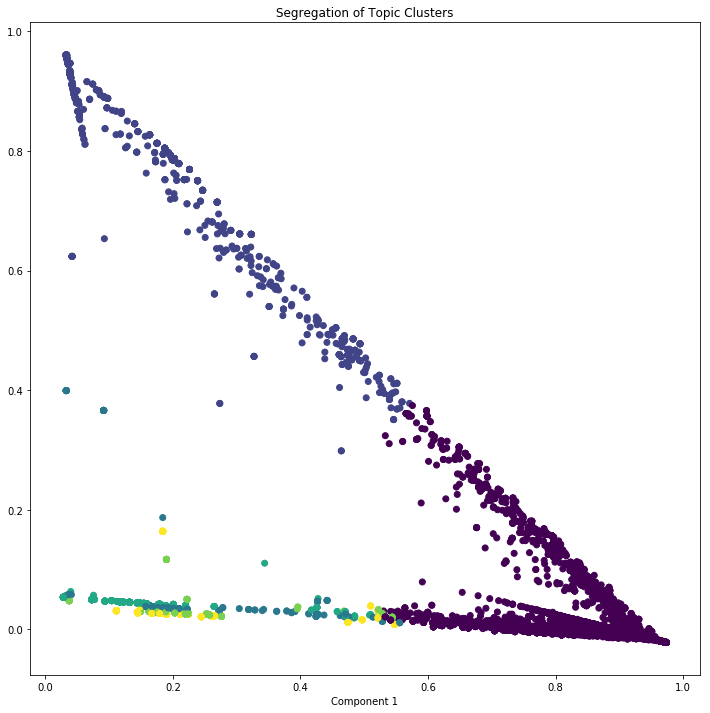

In [24]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=BEST_TOPICS, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plotting clusters
plotting_clusters(x, y, clusters)

In [25]:
from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents = corpus, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [26]:
# Get similar documents
doc_ids, docs = similar_documents(text=unseem_data, doc_topic_probs=lda_output, documents = corpus, top_n=1, verbose=True)
print('\n', docs[0][:500])

[[0.01267311 0.93621695 0.01267812 0.01276832 0.01286414 0.01279936]] 1
Topic KeyWords:  ['health', 'peopl', 'patient', 'studi', 'year', 'research', 'care', 'child', 'hospit', 'drug', 'cancer', 'make', 'woman', 'new', 'time', 'diseas', 'medic', 'doctor']
Topic Prob Scores of text:  [[0.  0.9 0.  0.  0.  0. ]]
Most Similar Doc's Probs:   [[0.  0.9 0.  0.  0.  0. ]]

 peopl use statin drug lower cholesterol sometim complain muscl pain sore new studi suggest case side effect may be result combin statin other medic research find peopl take statin have risk muscl pain when be prescrib various other drug often side effect be prompt peopl stop take statin peopl studi quit use statin could not toler be averag take as mani other drug could increas risk side effect statin be most wide prescrib drug world use rough american reduc risk heart attack stroke new research 


### Fitting with DBSCAN

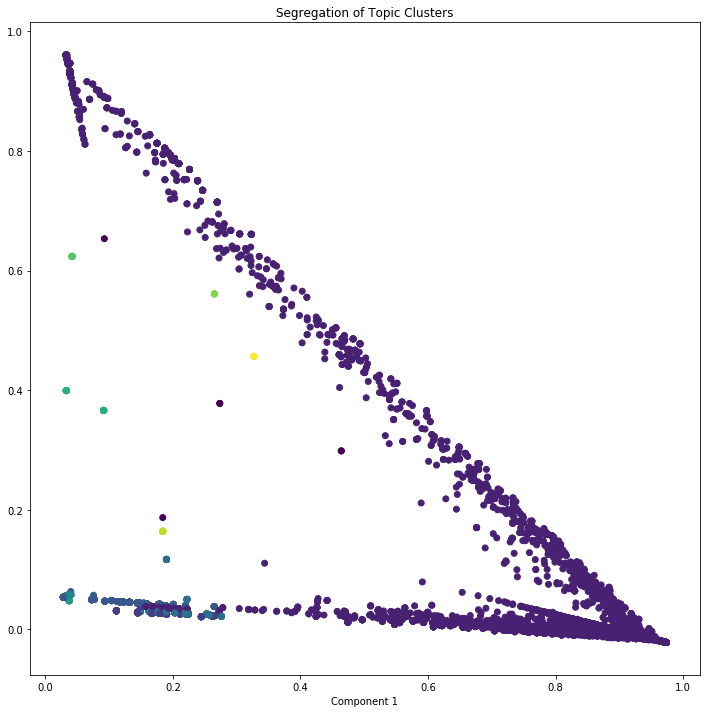

In [27]:
# Construct the DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# X = ss.fit_transform(lda_output)

dbscan_clusters = DBSCAN(eps=0.123, min_samples = 4).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plotting clusters
plotting_clusters(x, y, dbscan_clusters)